<a href="https://colab.research.google.com/github/InbumS/DreamscomeTrue/blob/main/DropBlock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DropBlock, A regularization method for convolutional networks 


딥러닝 모델에 있어 train data의 과적합을 막기 위해 여러 방법이 존재(ex: weight decay, drop out)

drop out은 convolutional layer에 영향력이 없어 과적합을 불러일으킴.
 
DropBlock ==> skip connection과 convolutional layer을 적용해 정확도를 높이며 하이퍼파라미터에 robust하게 만든다.

### DropBlock

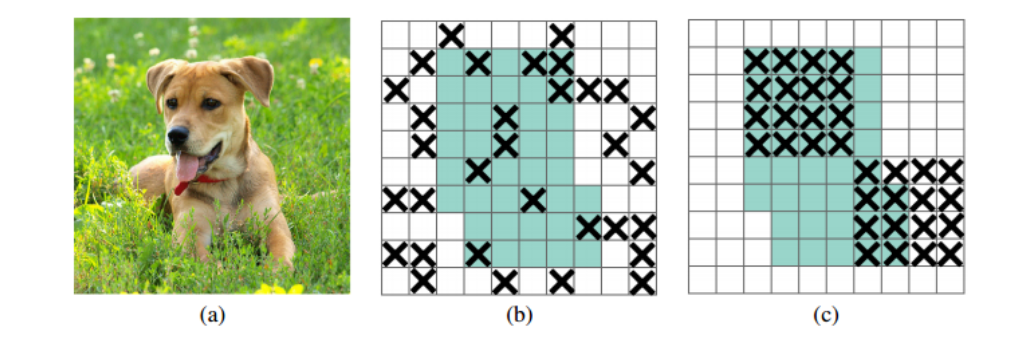

무작위로 제거하지 않고 연속적으로 밀집한 부분을 제거하는 방식(붙어있는 pixel 제거를 통해 더 확실하다)






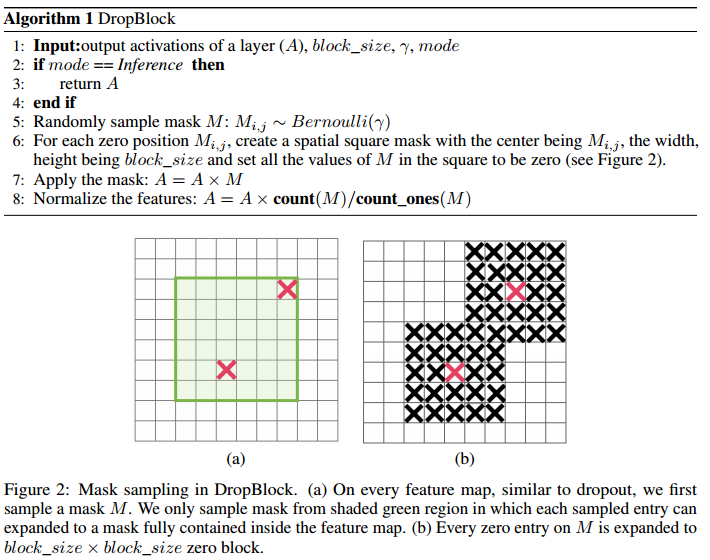

두개의 하이퍼 파라미터 1) block size => drop할 영역의 크기 조절
2) r => 이항 분포의 모수를 사용하여 pixel의 중심점 개수 조절


논문에서의 r을 구하는 식

---
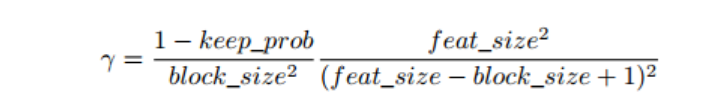


* keep_prob는 dropout에서의 keep_prob와 동일한 의미를 지닙니다. feat_size는 feature map size를 의미한다.

* 우선 keep_prob를 0.75~0.95 사이로 설정하는게 보통
 

*  dropblock은 학습 동안 고정된 keep_prob를 사용하는 경우에 효과적으로 작동하지 않습니다. 학습 초반에는 keep_prob를 낮은 값으로 설정하여 학습이 진행될 수록 선형적으로 keep_prob를 target_prob까지 증가시킵니다. 증가시키는 비율은 하이퍼파라미터 입니다.



In [ ]:
#dropblock 코드 구현
import torch

class DropBlock(torch.nn.module):
    def __init__(self, block_size=7, keep_prob=0.9):
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.gamma = None
        self.kernel_size = (block_size, block_size)
        self.stride = (1, 1)
        self.padding = (block_size//2, block_size//2)
    
    def calculate_gamma(self, x):
        return (1 - self.keep_prob) * x.shape[-1]**2/\
                (self.block_size**2 * (x.shape[-1] - self.block_size + 1)**2) 
    
    def forward(self, x):
        if not self.training:
            return x
        if self.gamma is None:
            self.gamma = self.calculate_gamma(x)
        p = torch.ones_like(x) * self.gamma
        mask = 1 - torch.nn.functional.max_pool2d(torch.bernoulli(p),
                                                  self.kernel_size,
                                                  self.stride,
                                                  self.padding)
        return mask * x * (mask.numel()/mask.sum())